In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')


In [2]:

# Load the dataset
print("Loading sales data...")
sales_data = pd.read_csv('../sales_data.csv')


Loading sales data...


In [3]:

# 1. Data Preprocessing
print("\n--- Data Preprocessing ---")



--- Data Preprocessing ---


In [4]:

# Check for missing values
print(f"Missing values in the dataset: {sales_data.isnull().sum().sum()}")


Missing values in the dataset: 0


In [5]:

# Sort data by time for proper sequence
sales_data = sales_data.sort_values(['distributor_id', 'sku', 'time_idx'])

print("\n--- Feature Engineering for TFT ---")
print("Temporal Fusion Transformer requires specific feature categories:")
print("1. Static features - constant over time for a given entity")
print("2. Time-varying known features - known in advance for forecasting steps")
print("3. Time-varying unknown features - not known in advance for future periods")
print("4. Target variable - what we're trying to predict")



--- Feature Engineering for TFT ---
Temporal Fusion Transformer requires specific feature categories:
1. Static features - constant over time for a given entity
2. Time-varying known features - known in advance for forecasting steps
3. Time-varying unknown features - not known in advance for future periods
4. Target variable - what we're trying to predict


In [6]:

# 2. Feature Categorization


In [7]:

# Static features (constant for each distributor-sku combination)
static_features = ['distributor_id', 'industry', 'sku', 'category', 'movement_category']


In [8]:

# Time-varying known features (known at forecast time)
time_varying_known_features = [
    'quarter', 'year', 
    'is_diwali', 'is_ganesh_chaturthi', 'is_gudi_padwa', 'is_eid',
    'is_akshay_tritiya', 'is_dussehra_navratri', 'is_onam', 'is_christmas'
]


In [9]:

# Time-varying unknown features (not known at forecast time)
time_varying_unknown_features = ['prev_quarter_sales', 'total_quarter_sales', 'avg_quarterly_sales']


In [10]:

# Target variable
target = 'sales'


In [11]:

print("\n--- Feature Counts ---")



--- Feature Counts ---


In [12]:
print(f"Static features: {len(static_features)}")
print(f"Time-varying known features: {len(time_varying_known_features)}")
print(f"Time-varying unknown features: {len(time_varying_unknown_features)}")


Static features: 5
Time-varying known features: 10
Time-varying unknown features: 3


In [13]:
# 3. Feature Transformations


In [14]:

# Create unique identifiers for each distributor-SKU pair
sales_data['entity_id'] = sales_data['distributor_id'] + '_' + sales_data['sku']
print(f"\nNumber of unique entities (distributor-SKU combinations): {sales_data['entity_id'].nunique()}")



Number of unique entities (distributor-SKU combinations): 1663


In [15]:

# Encode categorical features
label_encoders = {}
for feature in static_features:
    if sales_data[feature].dtype == 'object':
        encoder = LabelEncoder()
        sales_data[f"{feature}_encoded"] = encoder.fit_transform(sales_data[feature])
        label_encoders[feature] = encoder
        print(f"Encoded {feature} with {len(encoder.classes_)} unique values")


Encoded distributor_id with 50 unique values
Encoded industry with 8 unique values
Encoded sku with 200 unique values
Encoded category with 13 unique values
Encoded movement_category with 3 unique values


In [16]:

# Create cyclical encoding for quarter
sales_data['quarter_sin'] = np.sin(2 * np.pi * sales_data['quarter'] / 4)
sales_data['quarter_cos'] = np.cos(2 * np.pi * sales_data['quarter'] / 4)


In [17]:

# Scale numeric features
numeric_features = ['prev_quarter_sales', 'total_quarter_sales', 'avg_quarterly_sales', 'sales']
scaler = StandardScaler()
sales_data[numeric_features] = scaler.fit_transform(sales_data[numeric_features])


In [19]:

# Save scaler for inference
import joblib
joblib.dump(scaler, '../models/feature_scaler.joblib')


['../models/feature_scaler.joblib']

In [20]:

# 4. Time Series Specific Feature Engineering


In [21]:

# Calculate sales momentum (change from previous quarter)
sales_data['sales_momentum'] = sales_data.groupby(['entity_id'])['sales'].diff()


In [22]:

# Calculate average sales across all products for each distributor by quarter
distributor_quarter_avg = sales_data.groupby(['distributor_id', 'year', 'quarter'])['sales'].transform('mean')
sales_data['distributor_quarter_avg'] = distributor_quarter_avg


In [23]:

# Calculate average sales across all distributors for each product by quarter
product_quarter_avg = sales_data.groupby(['sku', 'year', 'quarter'])['sales'].transform('mean')
sales_data['product_quarter_avg'] = product_quarter_avg


In [24]:

# 5. Festival Impact Features


In [25]:

# Create combined festival indicator
sales_data['has_festival'] = (sales_data[['is_diwali', 'is_ganesh_chaturthi', 'is_gudi_padwa', 'is_eid',
                                        'is_akshay_tritiya', 'is_dussehra_navratri', 'is_onam', 
                                        'is_christmas']].sum(axis=1) > 0).astype(int)


In [26]:

# Count festivals in each quarter
sales_data['festival_count'] = sales_data[['is_diwali', 'is_ganesh_chaturthi', 'is_gudi_padwa', 'is_eid',
                                         'is_akshay_tritiya', 'is_dussehra_navratri', 'is_onam', 
                                         'is_christmas']].sum(axis=1)


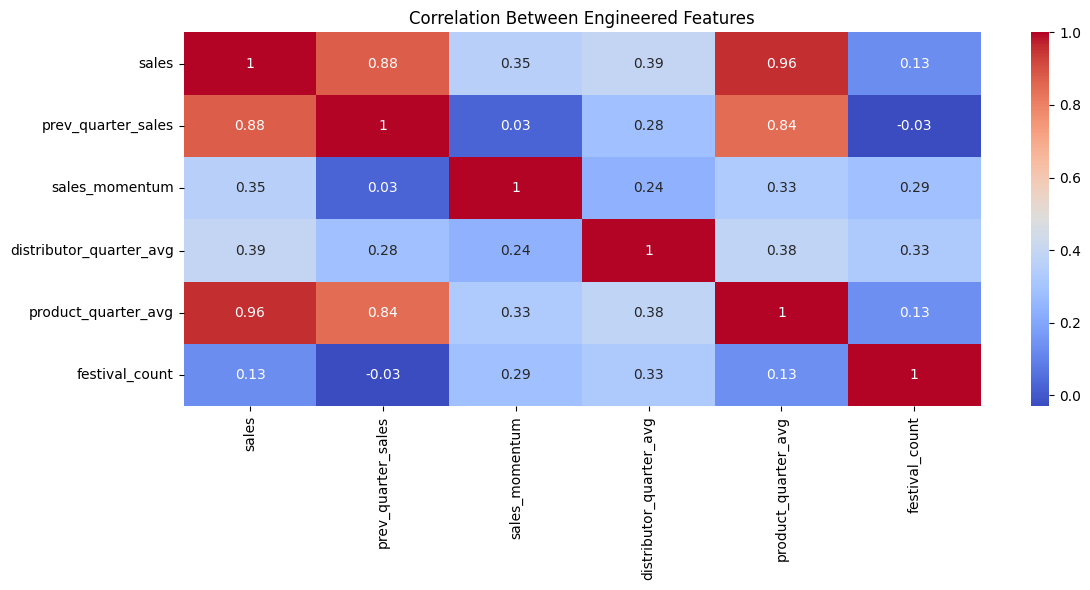

In [27]:

# 6. Visualize Engineered Features
plt.figure(figsize=(12, 6))
sns.heatmap(sales_data[['sales', 'prev_quarter_sales', 'sales_momentum', 
                        'distributor_quarter_avg', 'product_quarter_avg',
                        'festival_count']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Engineered Features')
plt.tight_layout()
plt.show()


In [28]:

# 7. Prepare Data for TFT Format


In [29]:

# Group by entity and sort by time
grouped_data = []
for entity, group in sales_data.groupby('entity_id'):
    group = group.sort_values('time_idx')
    grouped_data.append(group)


In [30]:

print(f"\nData grouped by {len(grouped_data)} unique entities")



Data grouped by 1663 unique entities


In [31]:

# 8. Create train/validation/test splits
# For time series data, we need to split by time rather than random sampling


In [32]:

# Identify the time range
min_time_idx = sales_data['time_idx'].min()
max_time_idx = sales_data['time_idx'].max()
time_range = max_time_idx - min_time_idx


In [33]:

# Create splits (60%/20%/20%)
train_cutoff = min_time_idx + int(time_range * 0.6)
val_cutoff = min_time_idx + int(time_range * 0.8)


In [34]:

train_data = sales_data[sales_data['time_idx'] <= train_cutoff].copy()
val_data = sales_data[(sales_data['time_idx'] > train_cutoff) & 
                       (sales_data['time_idx'] <= val_cutoff)].copy()
test_data = sales_data[sales_data['time_idx'] > val_cutoff].copy()


In [35]:

print("\n--- Data Splits ---")
print(f"Training data: {len(train_data)} samples, time range: {train_data['time_idx'].min()} to {train_data['time_idx'].max()}")
print(f"Validation data: {len(val_data)} samples, time range: {val_data['time_idx'].min()} to {val_data['time_idx'].max()}")
print(f"Test data: {len(test_data)} samples, time range: {test_data['time_idx'].min()} to {test_data['time_idx'].max()}")



--- Data Splits ---
Training data: 6078 samples, time range: 6 to 22782
Validation data: 1955 samples, time range: 22783 to 30369
Test data: 1967 samples, time range: 30377 to 37966


In [36]:

# 9. Save processed data for model training
train_data.to_csv('../data/train_data.csv', index=False)
val_data.to_csv('../data/val_data.csv', index=False)
test_data.to_csv('../data/test_data.csv', index=False)


OSError: Cannot save file into a non-existent directory: '../data'

In [ ]:

# Save feature definitions for TFT model
feature_config = {
    'static_features': static_features,
    'time_varying_known_features': time_varying_known_features + ['quarter_sin', 'quarter_cos', 'festival_count'],
    'time_varying_unknown_features': time_varying_unknown_features + ['sales_momentum', 'distributor_quarter_avg', 'product_quarter_avg'],
    'target': target,
    'time_idx': 'time_idx',
    'entity_id': 'entity_id'
}


In [ ]:

import json
with open('../data/feature_config.json', 'w') as f:
    json.dump(feature_config, f)

print("\n--- Feature Engineering Complete ---")
print("Processed data saved to data folder")
print("Feature configuration saved to data/feature_config.json")


In [ ]:

# 10. Additional Visualizations of Engineered Features


In [ ]:

# Plot distribution of engineered features
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(sales_data['sales_momentum'].dropna(), kde=True)
plt.title('Sales Momentum Distribution')

plt.subplot(2, 2, 2)
sns.histplot(sales_data['distributor_quarter_avg'], kde=True)
plt.title('Distributor Quarter Average Sales Distribution')

plt.subplot(2, 2, 3)
sns.histplot(sales_data['product_quarter_avg'], kde=True)
plt.title('Product Quarter Average Sales Distribution')

plt.subplot(2, 2, 4)
sns.countplot(x='festival_count', data=sales_data)
plt.title('Festival Count Distribution')

plt.tight_layout()
plt.show()


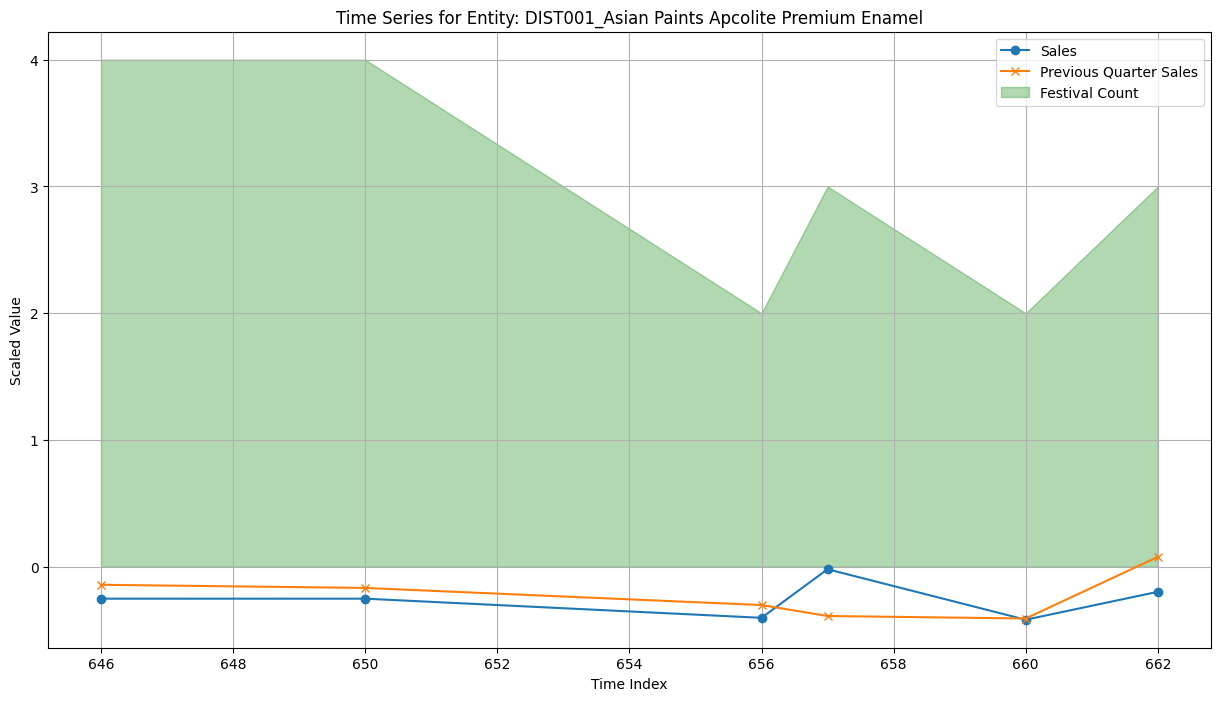

In [38]:

# Show example of time series for one entity
example_entity = sales_data['entity_id'].iloc[0]
example_data = sales_data[sales_data['entity_id'] == example_entity].sort_values('time_idx')

plt.figure(figsize=(15, 8))
plt.plot(example_data['time_idx'], example_data['sales'], marker='o', label='Sales')
plt.plot(example_data['time_idx'], example_data['prev_quarter_sales'], marker='x', label='Previous Quarter Sales')
plt.fill_between(example_data['time_idx'], 0, example_data['festival_count'], alpha=0.3, color='green', label='Festival Count')
plt.title(f'Time Series for Entity: {example_entity}')
plt.xlabel('Time Index')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.show()